In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss
from gru2 import GRUModel

In [2]:
x = np.loadtxt("x.dat", np.float32)
y = np.loadtxt("y.dat", np.float32)
x = x.reshape(x.shape[0], x.shape[1]//2, 2)
y = y.reshape(y.shape[0], y.shape[1]//1, 1)
grid = np.linspace(0, 1, 100, dtype=np.float32).reshape((100, 1))

print(x.shape)
print(y.shape)
print(grid.shape)

(1000, 100, 2)
(1000, 100, 1)
(100, 1)


In [3]:
# Parameters
nt = 100
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
model = GRUModel(400, 2, 1).cuda()
print(count_params(model))

485201


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
loss = LpLoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        out = out.reshape((out.shape[0], out.shape[1]))        
        
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            out = out.reshape((out.shape[0], out.shape[1]))
            test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))

0 0.30027973488904536 0.6783172501458062 0.5748858332633973
50 0.15857565682381392 0.08153831536571185 0.06718911305069923
100 0.15773346414789557 0.05118067343201902 0.04538915008306503
150 0.15980808506719768 0.036551692460974054 0.029734618589282037
200 0.1626297088805586 0.030100793639818827 0.02585916668176651
250 0.2087144199758768 0.02727864711648888 0.022750090435147287
300 0.156371905002743 0.02570270469619168 0.02170107625424862
350 0.15652967104688287 0.024969532009628086 0.021057286858558656
400 0.15658658812753856 0.024542423027257124 0.020788108929991722
450 0.15606669010594487 0.02431054465058777 0.020540406927466393
500 0.16646571992896497 0.024163288809359074 0.02042657509446144
550 0.1995880319736898 0.02408692975425058 0.02038719579577446
600 0.21040692296810448 0.024044817748169103 0.020356495305895804
650 0.16075970395468175 0.024023599674304327 0.020343052223324776
700 0.1616862458176911 0.024012587654093902 0.020334796980023384
750 0.16143552493304014 0.024007745

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


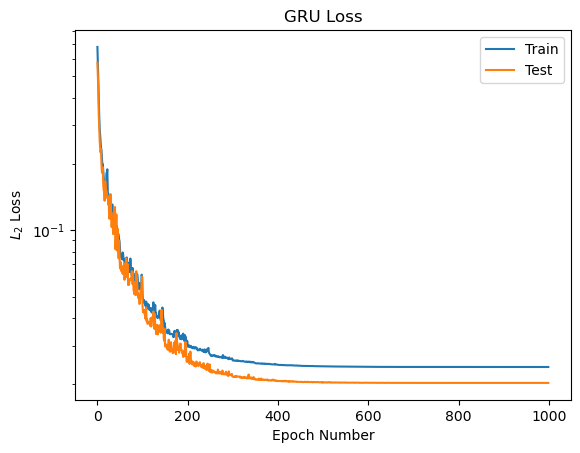

In [17]:
plt.plot(train_lossArr, label="Train")
plt.plot(test_lossArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.title("GRU Loss")
plt.legend()
plt.savefig("gruLinearLoss.eps")

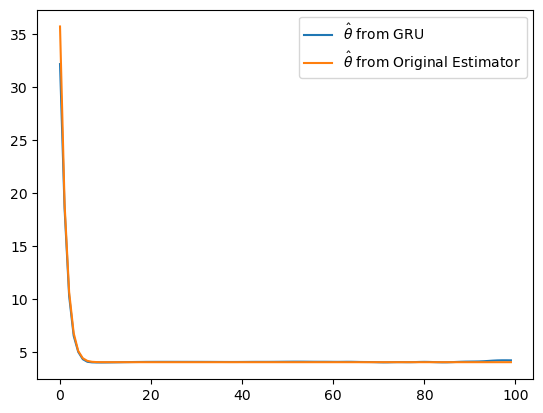

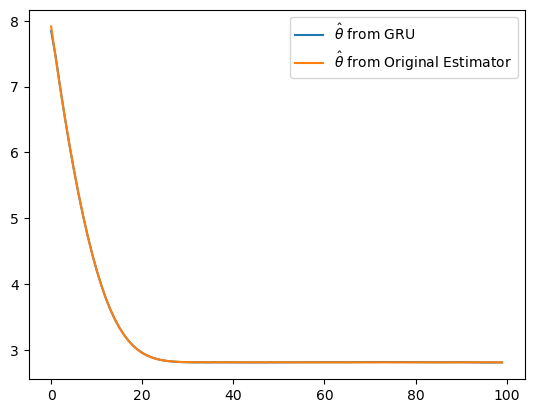

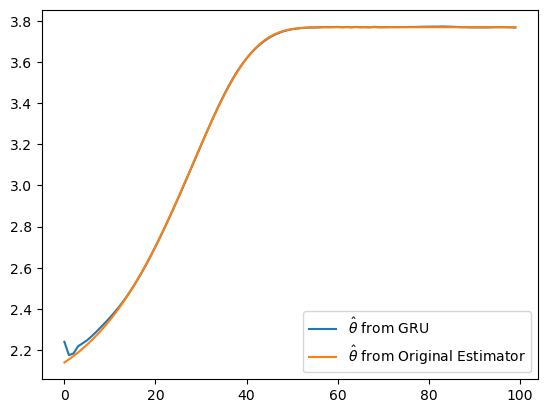

In [11]:
# Show some examples
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x)
        
    for i in range(3):
        plt.figure()
        plt.plot(out[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from GRU")
        plt.plot(y[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from Original Estimator")
        plt.legend()

In [14]:
with torch.no_grad():
    out_theta = []
    guess_theta = []
    test_loss = 0
    loss_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x)
        out = out.reshape((out.shape[0], out.shape[1]))
        
        for i in range(len(y)):
            out_theta.append(y[i][-1].cpu().detach())
            guess_theta.append(out[i][-1].cpu().detach())
            loss_end += (out_theta[-1]-guess_theta[-1])**2
        
        test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
print("TEST MSE:", test_loss/len(testData))
print("TEST MSE FINAL VALUE:", loss_end.item()/len(testData))

TEST MSE: 0.020330505073070528
TEST MSE FINAL VALUE: 0.03654609322547912


/home/luke/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/luke/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


Text(0, 0.5, 'Final $\\hat{\\theta}$ from GRU')

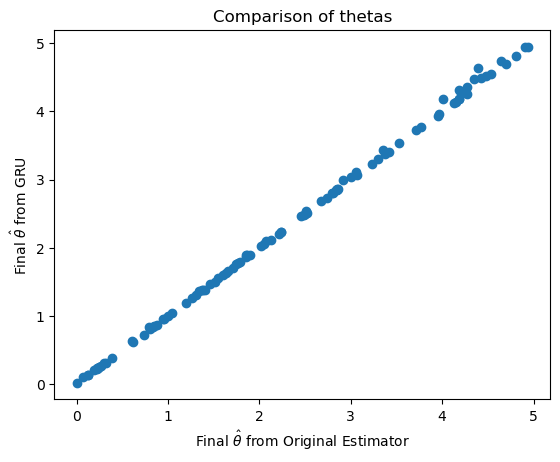

In [15]:
plt.title("Comparison of thetas")
plt.scatter(out_theta, guess_theta)
plt.xlabel(r"Final $\hat{\theta}$ from Original Estimator")
plt.ylabel(r"Final $\hat{\theta}$ from GRU")

In [16]:
# Save Model
torch.save(model.state_dict(), "gruModel1")